In [1]:

import joblib
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.GTFS import LINKED_TRIP_GROUPS, TIME_COLS
from matplotlib import dates
from datetime import datetime


UNIQUE_COLUMN_SET = ["trip_id", "date", "service_id", "block_id"]
REGRESSION_MODEL_PATH = "models/power_consumption_linear_regression.sav"
DESIGN_MATRIX_PATH = "datasets/design_matrix.csv"
WAYNE_TRIPS_PATH = "datasets/wayne_trips_to_PA.pkl"
TEMP_PATH = "datasets/Temperature.csv"
WAYNE_COLS = ["service_id", "block_id", "trip_id", "shape_dist_traveled", "duration", "time_waiting"]
BUS_BATTERY_CAPACITY = 364
MODEL = joblib.load(REGRESSION_MODEL_PATH)
RANDOM_STATE = 42
STATE = np.random.RandomState(RANDOM_STATE)


wayne_trips = pd.read_pickle(WAYNE_TRIPS_PATH)[WAYNE_COLS]
wayne_trips["duration_hours"] = wayne_trips.duration.apply(lambda x: x.total_seconds() / 3600)
wayne_trips["avg_speed"] = wayne_trips.apply(lambda row: row.shape_dist_traveled / row.duration_hours, axis=1)
services = pd.read_csv("datasets/gtfs/calendar_dates.txt", parse_dates=["date"], usecols=["date", "service_id"])
wayne_trips = wayne_trips.merge(services, on="service_id")


def assert_is_unique(df):
    assert df.groupby(UNIQUE_COLUMN_SET).filter(lambda x: len(x) > 1).shape[0] == 0


assert_is_unique(wayne_trips)


In [2]:

M = pd.read_csv(DESIGN_MATRIX_PATH)
temps = pd.read_csv(TEMP_PATH)
X1 = temps["Temperature"]
X2 = X1 ** 2
X3 = M["Speed"]

# Create bootstrap distribution
B, X3_stdev = wayne_trips.shape[0] * 50, np.std(X3)
bootstrap_wayne = wayne_trips.sample(n=B, replace=True, random_state=RANDOM_STATE)
bootstrap_wayne["temperature"] = STATE.choice(X1, B, replace=True)
bootstrap_wayne["temp_sq"] = bootstrap_wayne.temperature ** 2
bootstrap_wayne["speed"] = bootstrap_wayne.avg_speed.apply(lambda x: STATE.normal(loc=x, scale=X3_stdev))
bootstrap_wayne["speed"] = bootstrap_wayne.avg_speed
bootstrap_wayne["predicted_consumption_kW"] = MODEL.predict(bootstrap_wayne[["temperature", "temp_sq", "speed"]])
bootstrap_wayne["predicted_consumption_kWh"] = bootstrap_wayne.predicted_consumption_kW * bootstrap_wayne.duration_hours
bootstrap_wayne["rank"] = bootstrap_wayne.groupby(["date", "trip_id", "block_id", "service_id"])["predicted_consumption_kW"].rank(method="dense")


In [3]:

# Group by date, service_id, block_id, rank to get distribution of total predicted kWh per date-service-block
date_service_block_dists = bootstrap_wayne.groupby(["date", "service_id", "block_id", "rank"])["predicted_consumption_kWh"].sum()
date_service_block_99th = date_service_block_dists.reset_index().groupby(["date", "service_id", "block_id"])["predicted_consumption_kWh"].quantile(q=0.99).reset_index()

# Is date service block incomplete
date_service_block_99th["date_service_block_is_incomplete"] = (date_service_block_99th.predicted_consumption_kWh > BUS_BATTERY_CAPACITY).astype(int)
date_service_block_99th["date_service_block_kWh_deficit"] = date_service_block_99th.predicted_consumption_kWh - BUS_BATTERY_CAPACITY
date_service_block_99th.date_service_block_kWh_deficit = date_service_block_99th.date_service_block_kWh_deficit.apply(lambda x: 0 if x < 0 else x)
date_service_block_99th.head()

# Join block info back onto trip info
wayne_trips_dates = wayne_trips.merge(date_service_block_99th, on=["block_id", "service_id", "date"])
assert_is_unique(wayne_trips_dates)

# Write to pickle
date_service_block_99th.to_pickle("datasets/date_service_block_prediction_kWh.pkl")


In [69]:
#sns.kdeplot(bootstrap_wayne.predicted_consumption_kWh, bw_adjust=10)

#bootstrap_wayne.predicted_consumption_kWh[bootstrap_wayne.predicted_consumption_kWh < 0]

date_service_block_kWh = bootstrap_wayne.groupby(["date", "block_id", "service_id"])["predicted_consumption_kWh"].sum()

#sns.kdeplot(date_service_block_kWh, bw_adjust=0.5)
type(date_kWh_deficits.iloc[0])


pandas.core.series.Series

In [5]:

date_kWh_deficits = date_service_block_99th.groupby("date")[["date_service_block_kWh_deficit", "date_service_block_is_incomplete"]].sum().reset_index()
date_kWh_deficits["num_buses"] = np.ceil(date_kWh_deficits.date_service_block_kWh_deficit / BUS_BATTERY_CAPACITY)
date_kWh_deficits = date_kWh_deficits.sort_values(by="num_buses", ascending=False)
date_kWh_deficits.describe()


,date,date_service_block_kWh_deficit,date_service_block_is_incomplete,num_buses
count,180,180.000000,180.000000,180.000000
mean,2023-10-20 12:00:00,1397.919674,17.622222,4.338889
min,2023-07-23 00:00:00,608.468053,11.000000,2.000000
25%,2023-09-05 18:00:00,975.199353,14.000000,3.000000
50%,2023-10-20 12:00:00,1122.349604,16.000000,4.000000
75%,2023-12-04 06:00:00,2072.548147,19.250000,6.000000
max,2024-01-18 00:00:00,2767.685644,33.000000,8.000000
std,NaN,590.553649,5.061803,1.708225


In [6]:

# Get date-service-block length
date_service_block_length = wayne_trips_dates.groupby(["date"] + LINKED_TRIP_GROUPS)["trip_id"].count()
date_service_block_length = date_service_block_length.reset_index().rename({"trip_id": "num_trips"}, axis=1)
date_service_block_length.describe()


,date,service_id,num_trips
count,65282,65282.000000,65282.000000
mean,2023-10-20 17:58:41.252412672,3.404828,2.163414
min,2023-07-23 00:00:00,1.000000,1.000000
25%,2023-09-06 00:00:00,3.000000,1.000000
50%,2023-10-20 00:00:00,3.000000,2.000000
75%,2023-12-05 00:00:00,4.000000,3.000000
max,2024-01-18 00:00:00,7.000000,7.000000
std,NaN,0.755095,1.426866


In [7]:

wayne_trips_dates = wayne_trips_dates.merge(date_service_block_length, on=["date"] + LINKED_TRIP_GROUPS)
wayne_trips_dates.head()


,service_id,block_id,trip_id,shape_dist_traveled,duration,time_waiting,duration_hours,avg_speed,date,predicted_consumption_kWh,date_service_block_is_incomplete,date_service_block_kWh_deficit,num_trips
0,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.050000,20.786476,2023-07-29,385.50419,1,21.50419,6
1,1,160WY001,7930,22.2051,0 days 01:02:00,0 days 00:43:00,1.033333,21.488806,2023-07-29,385.50419,1,21.50419,6
2,1,160WY001,7917,21.8258,0 days 01:19:00,0 days 00:21:00,1.316667,16.576557,2023-07-29,385.50419,1,21.50419,6
3,1,160WY001,7933,22.2051,0 days 01:08:00,0 days 00:27:00,1.133333,19.592735,2023-07-29,385.50419,1,21.50419,6
4,1,160WY001,7920,21.8258,0 days 01:19:00,0 days 00:21:00,1.316667,16.576557,2023-07-29,385.50419,1,21.50419,6


In [8]:

assert_is_unique(wayne_trips_dates)

wayne_trips_dates["trip_predicted_consumption_kWh"] = wayne_trips_dates.predicted_consumption_kWh / wayne_trips_dates.num_trips

# Add field to calculate the max charging per the schedule
pa_stops = pd.read_pickle("datasets/wayne_trips_to_PA.pkl")[["trip_id", "is_port_authority_stop", "final_departure_time", "first_arrival_time"]]
wayne_trips_dates = wayne_trips_dates.merge(pa_stops, on=["trip_id"])

assert_is_unique(wayne_trips_dates)

wayne_trips_dates["max_charging_kWh"] = wayne_trips_dates.apply(lambda row: (row.time_waiting.total_seconds() / 3600) * (0.9*220) if row.is_port_authority_stop else 0, axis=1)
wayne_trips_dates.head()


,service_id,block_id,trip_id,shape_dist_traveled,duration,time_waiting,duration_hours,avg_speed,date,predicted_consumption_kWh,date_service_block_is_incomplete,date_service_block_kWh_deficit,num_trips,trip_predicted_consumption_kWh,is_port_authority_stop,final_departure_time,first_arrival_time,max_charging_kWh
0,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-07-29,385.504190,1,21.50419,6,64.250698,1,0 days 07:23:00,0 days 06:20:00,89.1
1,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-08-05,362.325181,0,0.00000,6,60.387530,1,0 days 07:23:00,0 days 06:20:00,89.1
2,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-08-12,359.799728,0,0.00000,6,59.966621,1,0 days 07:23:00,0 days 06:20:00,89.1
3,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-08-19,360.198399,0,0.00000,6,60.033066,1,0 days 07:23:00,0 days 06:20:00,89.1
4,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-08-26,348.791006,0,0.00000,6,58.131834,1,0 days 07:23:00,0 days 06:20:00,89.1


In [9]:

wayne_trips_dates = wayne_trips_dates.sort_values(by=["date"] + LINKED_TRIP_GROUPS + ["final_departure_time", "first_arrival_time"])

assert_is_unique(wayne_trips_dates)

# Get the rolling consumption
rolling_stats = wayne_trips_dates.groupby(["date"] + LINKED_TRIP_GROUPS)["trip_predicted_consumption_kWh"].expanding(1).sum().reset_index(level=[0, 1, 2])
rolling_stats = rolling_stats.rename({"trip_predicted_consumption_kWh": "rolling_consumption"}, axis=1)
rolling_stats.head()


,date,block_id,service_id,rolling_consumption
10400,2023-07-23,160WY001,2,80.352940
10426,2023-07-23,160WY001,2,160.705880
10452,2023-07-23,160WY002,2,101.735599
10478,2023-07-23,160WY002,2,203.471198
10504,2023-07-23,160WY003,2,88.805854


In [10]:

# Add rank to rolling
rolling_stats["rank"] = rolling_stats.groupby(["date"] + LINKED_TRIP_GROUPS)["rolling_consumption"].rank(method="dense")

wayne_trips_dates["rank"] = wayne_trips_dates.groupby(["date"] + LINKED_TRIP_GROUPS)["final_departure_time"].rank(method="dense")
wayne_trips_dates = wayne_trips_dates.sort_values(by=["date", "service_id", "block_id", "final_departure_time"])
wayne_trips_dates.head()

wayne_trips_rolling = wayne_trips_dates.merge(rolling_stats, on=["date", "rank"] + LINKED_TRIP_GROUPS)

assert_is_unique(wayne_trips_rolling)


In [11]:
# Add capacity less consumption & net capacity after charge
wayne_trips_rolling["capacity_less_consump"] = BUS_BATTERY_CAPACITY - wayne_trips_rolling["rolling_consumption"]
wayne_trips_rolling["current_trip_capacity_loss"] = wayne_trips_rolling["trip_predicted_consumption_kWh"] 
wayne_trips_rolling["current_charge_loss_diff"] = wayne_trips_rolling.max_charging_kWh - wayne_trips_rolling.current_trip_capacity_loss
wayne_trips_rolling["net_capacity_after_charge"] = wayne_trips_rolling.apply(lambda row: min(BUS_BATTERY_CAPACITY, row.capacity_less_consump + row.max_charging_kWh), axis=1)
wayne_trips_rolling.head()


def get_net_capacity(group_of_rows):
    current_capacity = BUS_BATTERY_CAPACITY
    for index, value in group_of_rows.iterrows():
        current_capacity = min(BUS_BATTERY_CAPACITY, current_capacity + value.current_charge_loss_diff)
    return current_capacity


In [12]:

# Apply get_net_capacity to each date, block, service
net_capacities = wayne_trips_rolling.groupby(["date"] + LINKED_TRIP_GROUPS).apply(get_net_capacity).reset_index()
net_capacities = net_capacities.rename({0: "net_capacity"}, axis=1)
incomplete = net_capacities[net_capacities.net_capacity < 0].copy()
incomplete["service_block"] = np.array(incomplete.service_id.astype(str).str.cat(incomplete.block_id, sep="-"))
incomplete_by_date = incomplete.groupby("date").agg({"net_capacity": "sum", "service_block": "nunique"}).reset_index()
incomplete_by_date["num_buses"] = np.ceil(np.abs(incomplete_by_date.net_capacity) / BUS_BATTERY_CAPACITY).astype(int)
incomplete_by_date = incomplete_by_date.sort_values(by="net_capacity", ascending=True)
incomplete_by_date = incomplete_by_date.sort_values(by="service_block", ascending=False)
incomplete_by_date


,date,net_capacity,service_block,num_buses
148,2023-12-24,-374.310180,6,2
113,2023-11-19,-626.260710,5,2
40,2023-09-03,-411.459278,5,2
46,2023-09-09,-260.953196,5,1
99,2023-11-05,-204.504047,5,1
...,...,...,...,...
31,2023-08-25,-43.557564,1,1
77,2023-10-14,-42.528009,1,1
129,2023-12-05,-37.798097,1,1
109,2023-11-15,-35.936479,1,1


In [13]:

# Get the worst day
worst_day = incomplete_by_date[incomplete_by_date.num_buses == incomplete_by_date.num_buses.max()].iloc[0,:].date

# Get the incomplete service blocks from that day
incomplete_service_blocks = incomplete[incomplete.date == worst_day][["date"] + LINKED_TRIP_GROUPS]

# Get the rolling information for these date-service-blocks
worst_rolling = wayne_trips_rolling.merge(incomplete_service_blocks, on=["date"] + LINKED_TRIP_GROUPS)

# Convert the interval to a datetime from timedelta
worst_rolling["hour"] = worst_rolling.final_departure_time.apply(lambda x: x.total_seconds() // 3600)
worst_rolling["Service-Block"] = worst_rolling.apply(lambda row: str(row.service_id) + "-" + row.block_id, axis=1)


In [51]:

# Some quick magic
y = worst_rolling.groupby("Service-Block")["hour"].min().to_dict()

new_entries = pd.concat([pd.DataFrame({"Service-Block": key, "hour": value - 1, "net_capacity": BUS_BATTERY_CAPACITY}, index=[str(key) + str(value)]) for key, value in y.items()])

worst_rolling = worst_rolling.sort_values(by=["Service-Block", "final_departure_time"])

def get_net_capacities(group_of_rows):
    current_capacities = []
    current_capacity = BUS_BATTERY_CAPACITY
    for index, value in group_of_rows.iterrows():
        current_capacity = min(BUS_BATTERY_CAPACITY, current_capacity + value.current_charge_loss_diff)
        current_capacities.append(current_capacity)
        if current_capacity < 0:
            break
    return current_capacities

service_block_groups = worst_rolling.groupby("Service-Block")
grouped_net_capacities = service_block_groups.apply(get_net_capacities)
exploded_net_capacities = grouped_net_capacities.explode().reset_index().rename({0: "net_capacity"}, axis=1)
exploded_net_capacities["rank"] = exploded_net_capacities.groupby("Service-Block")["net_capacity"].cumcount() + 1
worst_rolling["rank"] = worst_rolling.groupby("Service-Block")["final_departure_time"].cumcount() + 1
worst_rolling_rank = worst_rolling[["Service-Block", "hour", "rank"]].merge(exploded_net_capacities, on=["Service-Block", "rank"])
worst_rolling_rank

#insufficient_service_blocks = worst_rolling
#worst_rolling_rank[["Service-Block", "hour", "net_capacity"]]
graph_df = pd.concat([new_entries, worst_rolling_rank[["Service-Block", "hour", "net_capacity"]]], axis=0)
exploded_net_capacities

#graph_df
#grouped_net_capacities.explode()
#new_entries


,Service-Block,net_capacity,rank
0,2-191WY004,203.414851,1
1,2-191WY004,-26.470298,2
2,2-191WY010,272.669538,1
3,2-191WY010,112.039076,2
4,2-191WY010,-2.391386,3
5,2-191WY015,305.685611,1
6,2-191WY015,178.071222,2
7,2-191WY015,106.556833,3
8,2-191WY015,-21.057556,4
9,2-191WY016,295.751763,1


<Axes: xlabel='hour', ylabel='net_capacity'>

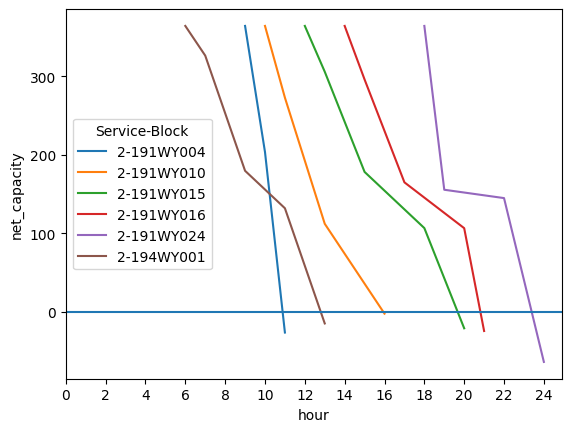

In [42]:
graph = sns.lineplot(data=graph_df, x="hour", y="net_capacity", hue="Service-Block")
graph.axhline(0)

graph.set_xticks(range(0, 25, 2))
graph

In [54]:
worst_rolling[worst_rolling["Service-Block"] == "2-191WY004"][["trip_predicted_consumption_kWh", "shape_dist_traveled", "current_charge_loss_diff", "avg_speed", "final_departure_time", "first_arrival_time"]]


,trip_predicted_consumption_kWh,shape_dist_traveled,current_charge_loss_diff,avg_speed,final_departure_time,first_arrival_time
0,229.885149,64.0076,-160.585149,30.239811,0 days 10:09:00,0 days 08:02:00
1,229.885149,39.0938,-229.885149,30.072154,0 days 11:48:00,0 days 10:30:00


In [ ]:
missing_capacity = abs(int(insufficient_service_blocks.groupby(LINKED_TRIP_GROUPS)["net_capacity"].nth([-1]).sum()))
buses_required = int(np.ceil(abs(missing_capacity) / BUS_BATTERY_CAPACITY))
print(f"The number of buses required is {buses_required} for a capacity deficit of {missing_capacity} kWh")


In [ ]:
num_trips = wayne_trips.trip_id.nunique()
num_blocks = wayne_trips.block_id.nunique()
num_services = wayne_trips.service_id.nunique()
num_service_blocks = wayne_trips[LINKED_TRIP_GROUPS].drop_duplicates().shape[0]

print(f"There are {num_trips} trips across {num_blocks} blocks and {num_services} service days. There are {num_service_blocks} total service blocks.")